In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src.tools import freeze
from src.tools import load_dataset
from src.cunet import CUNet

import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
from collections import OrderedDict

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

## Main Config

In [2]:
DEVICE_ID = 3

# DATASET2, DATASET2_PATH = 'handbag', '../../data/handbag_128.hdf5'
DATASET2, DATASET2_PATH = 'shoes', '../../data/shoes_128.hdf5'
# DATASET1, DATASET1_PATH = 'celeba_female', '../../data/img_align_celeba'
# DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../data/aligned_anime_faces'
# DATASET1, DATASET1_PATH = 'outdoor', '../../data/outdoor_128.hdf5'
# DATASET2, DATASET2_PATH = 'church', '../../data/church_128.hdf5'
DATASET1, DATASET1_PATH = 'dtd', '../../data/dtd/images'

IMG_SIZE = 128
COST = 'energy' #'weak_mse'

ZC, Z_STD = 128, 1.
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_ID}')

In [3]:
_, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, img_size=IMG_SIZE)
# _, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE) <-- not needed in this notebook
    
T = CUNet(3, 3, ZC, base_factor=48)
pass

In [4]:
folder = os.path.join('../checkpoints', COST, '{}_{}_{}'.format(DATASET1, DATASET2, IMG_SIZE))
model = 'T.pt'
path = os.path.join(folder, model)

In [5]:
T.load_state_dict(torch.load(path))
T.cuda(); freeze(T)

## Plotting checkpoints

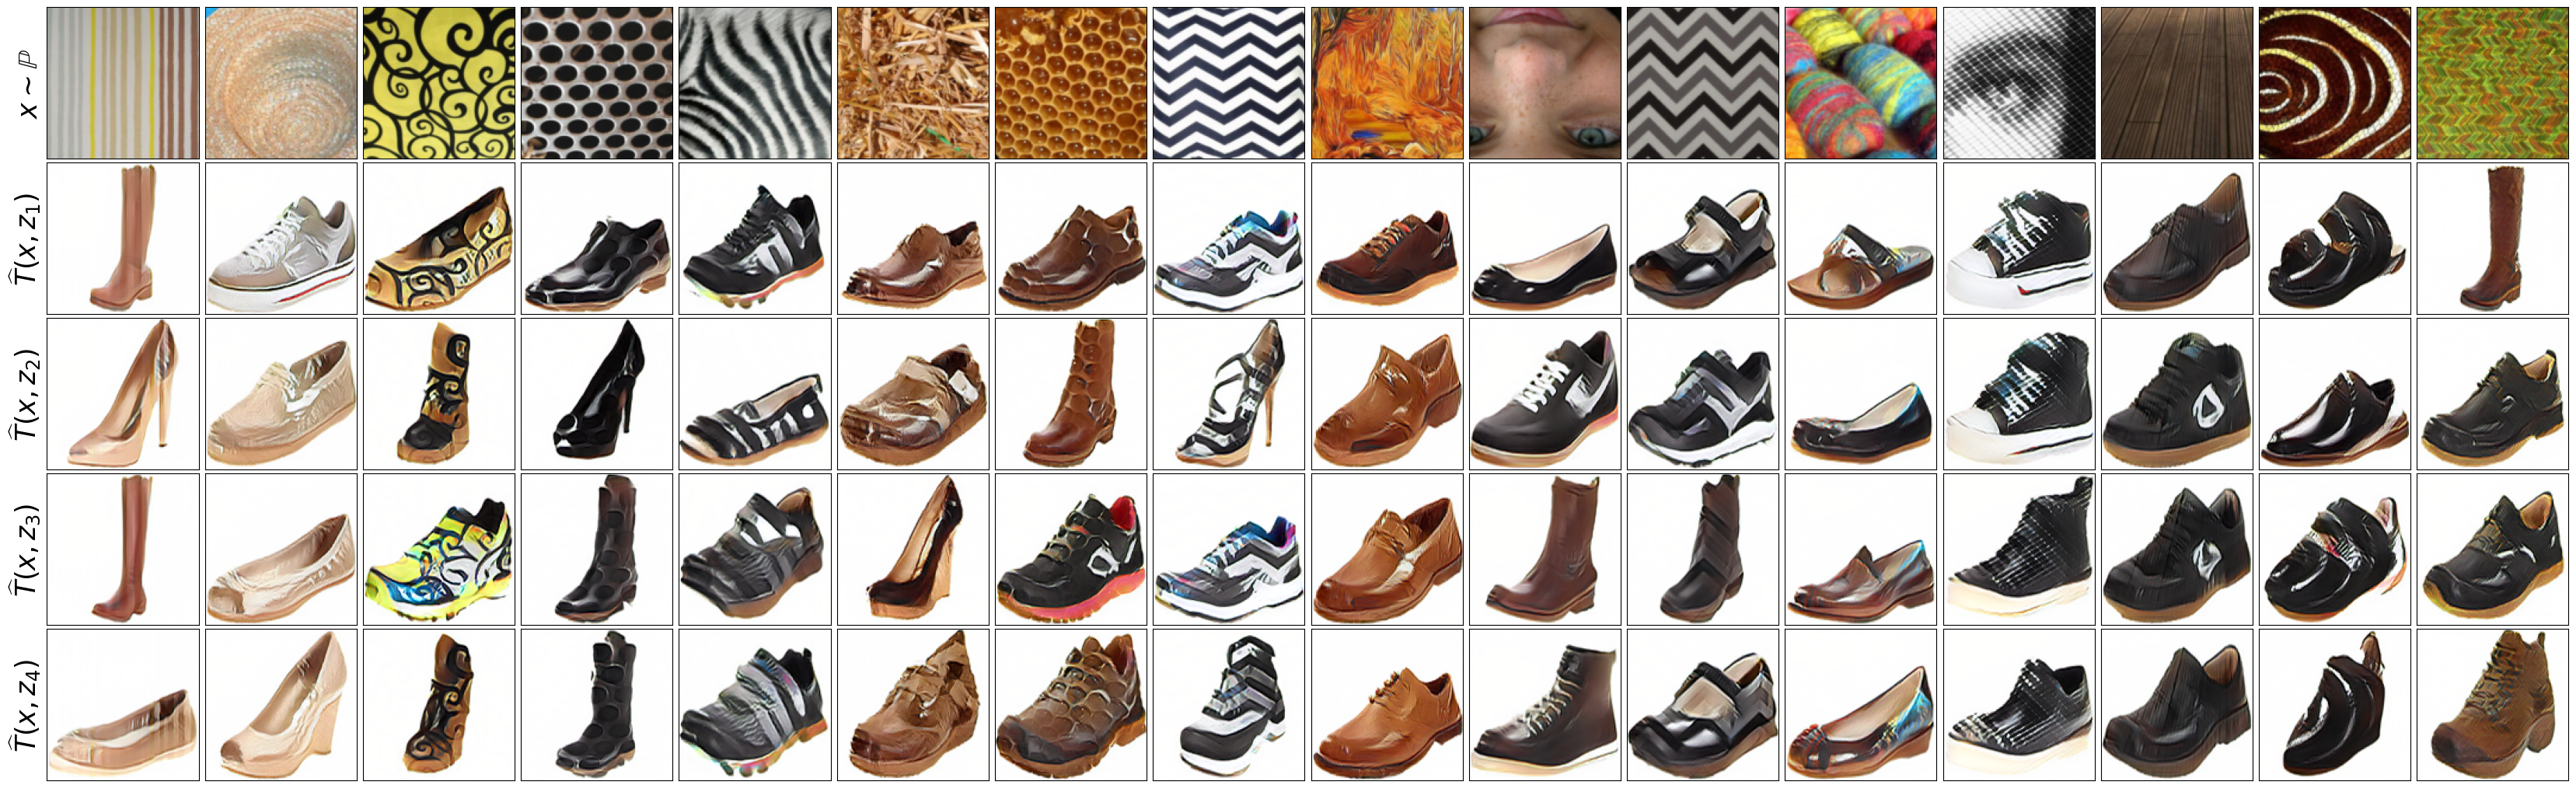

In [6]:
fig, axes = plt.subplots(5, 16, figsize=(16*2+1,10), dpi=100)   

X = X_test_sampler.sample(16)[:,None].repeat(1,4,1,1,1)

# CUNet
with torch.no_grad():
    Z = torch.randn(16, 4, ZC, 1, 1, device='cuda') * Z_STD
    T_XZ = T(
        X.flatten(start_dim=0, end_dim=1), Z.flatten(start_dim=0, end_dim=1)
    ).permute(1,2,3,0).reshape(3, IMG_SIZE, IMG_SIZE, -1, 4).permute(3,4,0,1,2)

with torch.no_grad():
    for i in range(16):
        axes[0,i].imshow(X[i, 0].permute(1, 2, 0).add(1).mul(0.5).cpu().numpy().clip(0,1))
        for j in range(4):
            axes[j+1,i].imshow(T_XZ[i,j].permute(1, 2, 0).add(1).mul(0.5).cpu().numpy().clip(0,1))

axes[0,0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=25 if IMG_SIZE==128 else 30)
for j in range(4):
    title = '\widehat{T}(x,z_' + str(j+1) + ')'
    axes[j+1,0].set_ylabel(r'${}$'.format(title), fontsize=25 if IMG_SIZE==128 else 30)

for i, ax in enumerate(axes.flatten()):
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])

fig.tight_layout(pad=0.001)
fig.show()

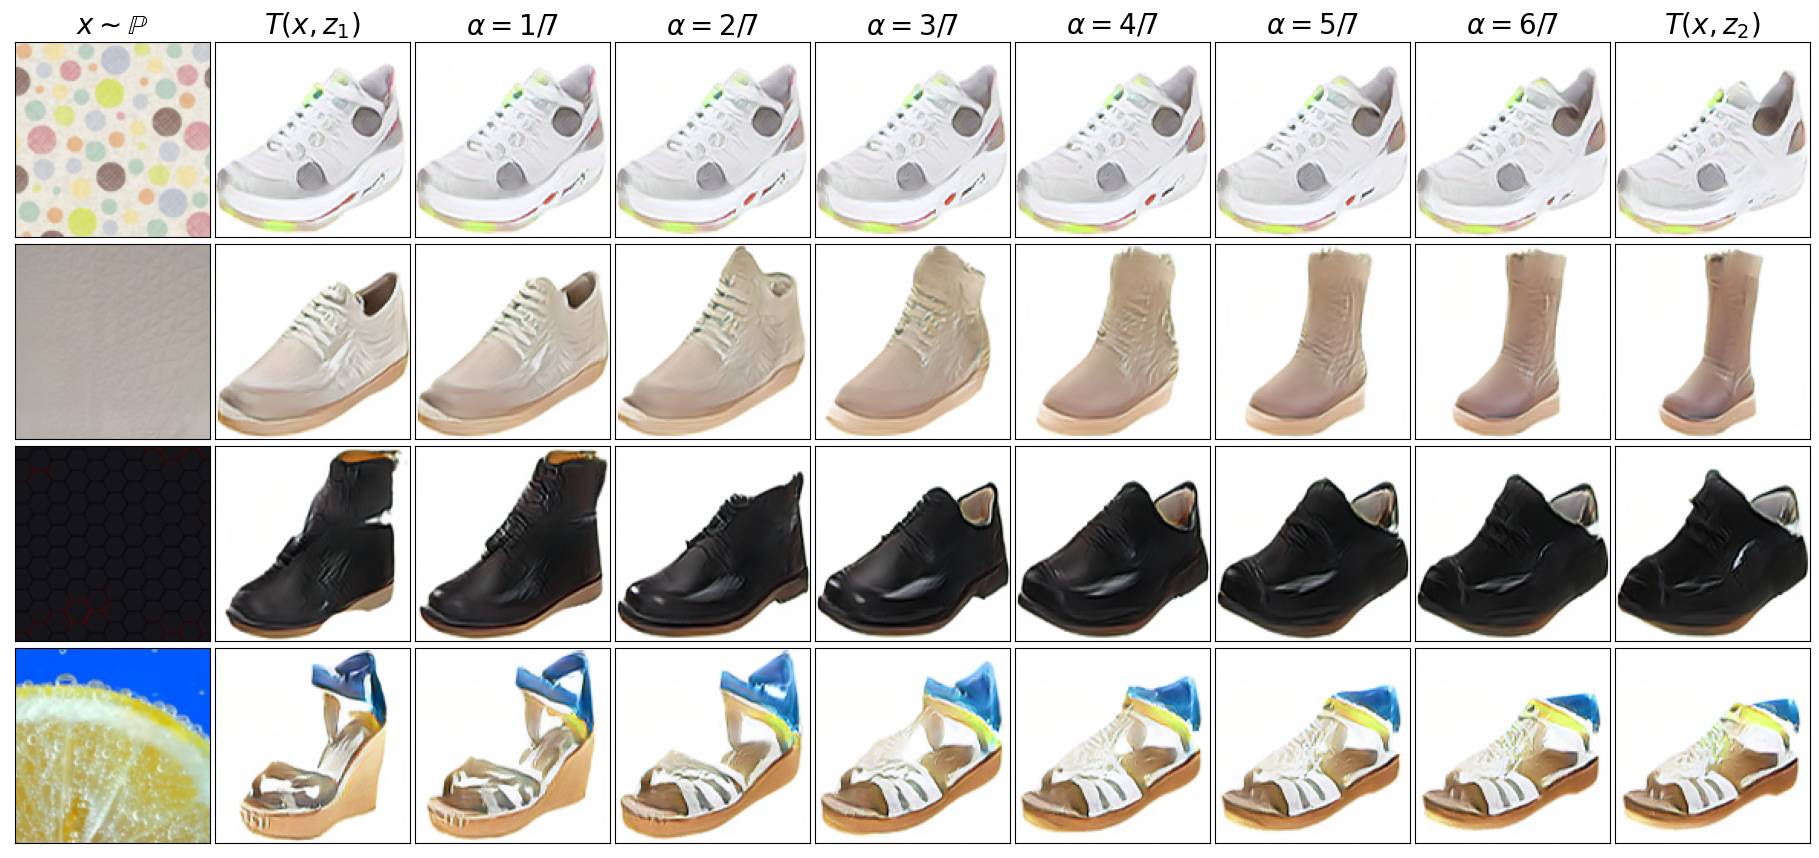

In [7]:
Z_SIZE = 8 if IMG_SIZE == 128 else 11
fig, axes = plt.subplots(4, Z_SIZE+1, figsize=((Z_SIZE+1)*2,8+0.4), dpi=100)  

X = X_test_sampler.sample(4)[:,None].repeat(1,Z_SIZE,1,1,1)
with torch.no_grad():
    Z = torch.randn(X.size(0), Z_SIZE, ZC, 1, 1, device='cuda') * Z_STD
    for i in range(Z_SIZE):
        Z[:, i] = Z[:, 0]*(1.-i/(Z_SIZE-1)) + Z[:,-1]*(i/(Z_SIZE-1))
    T_XZ = T(
        X.flatten(start_dim=0, end_dim=1), Z.flatten(start_dim=0, end_dim=1)
    ).permute(1,2,3,0).reshape(3, IMG_SIZE, IMG_SIZE, -1, Z_SIZE).permute(3,4,0,1,2)

with torch.no_grad():
    for j in range(4):
        axes[j,0].imshow(X[j, 0].permute(1, 2, 0).add(1).mul(0.5).cpu().numpy().clip(0,1))
        for i in range(Z_SIZE):
            axes[j,i+1].imshow(T_XZ[j,i].permute(1, 2, 0).add(1).mul(0.5).cpu().numpy().clip(0,1))

for i in range(1,Z_SIZE-1):
    title = '\\alpha={}/{}'.format(i,Z_SIZE-1)
    axes[0,i+1].set_title(r'${}$'.format(title), fontsize=20 if IMG_SIZE==128 else 25)
axes[0,0].set_title(r'$x\sim\mathbb{P}$', fontsize=20 if IMG_SIZE==128 else 25)
axes[0,1].set_title(r'$T(x,z_1)$', fontsize=20 if IMG_SIZE==128 else 25)
axes[0,-1].set_title(r'$T(x,z_2)$', fontsize=20 if IMG_SIZE==128 else 25)

for i, ax in enumerate(axes.flatten()):
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])

fig.tight_layout(pad=0.001)
fig.show()